In [4]:
import requests

def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print("File downloaded successfully!")
    else:
        print("Failed to download file.")

# Example usage
url = "https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt"
save_path = "PM_truth.txt"
download_file(url, save_path)

File downloaded successfully!


In [5]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'binary_model.h5'

In [6]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [7]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [8]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [9]:
seq_array.shape

(15631, 50, 25)

In [10]:
label_array.shape

(15631, 1)

In [11]:
label_array.dtype

dtype('float32')

In [12]:
model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
75/75 - 24s - loss: 0.2551 - accura

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import imdb
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding,Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi 
import tensorflow as tf
import time
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi 

In [15]:
# Define the NeuralNetworkModel class
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_lstm(self, input_shape, num_classes, optimizer):
        self.model = Sequential()
        self.model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(units=50, input_shape=input_shape, return_sequences=False))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(num_classes, activation='sigmoid'))  # Assuming 3 classes for classification
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, train_generator, val_generator, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        history = self.model.fit(train_generator, val_generator, epochs=epochs, batch_size=batch_size, validation_split=0.05, callbacks=[early_stopping, reduce_lr])
        return history

    
    def evaluate(self, X_test, y_test):
        # # Generate predictions
        # y_pred_prob = self.model.predict(test_generator)

        # # Extract true labels from test generator
        # y_true = []
        # for i in range(len(test_generator)):
        #     _, labels = test_generator[i]
        #     y_true.extend(labels)
        # y_true = np.argmax(y_true, axis=1)

        # # Convert predictions to class labels
        # y_pred = np.argmax(y_pred_prob, axis=1)

        # # Compute evaluation metrics
        # accuracy = accuracy_score(y_true, y_pred)
        # precision = precision_score(y_true, y_pred, average='weighted')
        # recall = recall_score(y_true, y_pred, average='weighted')
        # f1 = f1_score(y_true, y_pred, average='weighted')

        # return accuracy, precision, recall, f1
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        return accuracy, precision, recall, f1


In [16]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_lstm((sequence_length, nb_features), num_classes= nb_out ,optimizer=optimizer)
    start_time = time.time()
    # history = neural_network_model.train(train_generator, y_train, val_generator, y_val, epochs=1, batch_size=32)
    history = neural_network_model.train(seq_array, label_array, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(seq_array, label_array)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
465/465 [==============================] - 12s 20ms/step - loss: 0.3834 - accuracy: 0.8353 - val_loss: 0.2824 - val_accuracy: 0.8657 - lr: 0.0100
Epoch 2/50
465/465 [==============================] - 8s 18ms/step - loss: 0.1978 - accuracy: 0.9231 - val_loss: 0.2106 - val_accuracy: 0.9143 - lr: 0.0100
Epoch 3/50
465/465 [==============================] - 8s 18ms/step - loss: 0.1431 - accuracy: 0.9452 - val_loss: 0.1558 - val_accuracy: 0.9348 - lr: 0.0100
Epoch 4/50
465/465 [==============================] - 8s 18ms/step - loss: 0.1138 - accuracy: 0.9550 - val_loss: 0.0953 - val_accuracy: 0.9565 - lr: 0.0100
Epoch 5/50
465/465 [==============================] - 8s 18ms/step - loss: 0.0965 - accuracy: 0.9608 - val_loss: 0.0742 - val_accuracy: 0.9668 - lr: 0.0100
Epoch 6/50
465/465 [==============================] - 9s 18ms/step - loss: 0.0895 - accuracy: 0.9644 - val_loss: 0.0727 - val_accuracy: 0.9706 - lr: 0.0100
Epoch 7/50
465/465 [======

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with SGD_momentum optimizer...
Epoch 1/50
465/465 [==============================] - 13s 22ms/step - loss: 0.2292 - accuracy: 0.9078 - val_loss: 0.1576 - val_accuracy: 0.9258 - lr: 0.0100
Epoch 2/50
465/465 [==============================] - 9s 20ms/step - loss: 0.1242 - accuracy: 0.9484 - val_loss: 0.0645 - val_accuracy: 0.9693 - lr: 0.0100
Epoch 3/50
465/465 [==============================] - 9s 20ms/step - loss: 0.1066 - accuracy: 0.9564 - val_loss: 0.0893 - val_accuracy: 0.9616 - lr: 0.0100
Epoch 4/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0818 - accuracy: 0.9669 - val_loss: 0.0632 - val_accuracy: 0.9731 - lr: 0.0100
Epoch 5/50
465/465 [==============================] - 9s 20ms/step - loss: 0.0796 - accuracy: 0.9651 - val_loss: 0.1149 - val_accuracy: 0.9552 - lr: 0.0100
Epoch 6/50
465/465 [==============================] - 9s 20ms/step - loss: 0.0748 - accuracy: 0.9679 - val_loss: 0.0660 - val_accuracy: 0.9655 - lr: 0.0100
Epoch 7/50
465/46

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Nesterov optimizer...
Epoch 1/50
465/465 [==============================] - 13s 21ms/step - loss: 0.2040 - accuracy: 0.9164 - val_loss: 0.1645 - val_accuracy: 0.9348 - lr: 0.0100
Epoch 2/50
465/465 [==============================] - 9s 20ms/step - loss: 0.0946 - accuracy: 0.9596 - val_loss: 0.0688 - val_accuracy: 0.9719 - lr: 0.0100
Epoch 3/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0775 - accuracy: 0.9674 - val_loss: 0.0625 - val_accuracy: 0.9655 - lr: 0.0100
Epoch 4/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0707 - accuracy: 0.9687 - val_loss: 0.0582 - val_accuracy: 0.9770 - lr: 0.0100
Epoch 5/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0699 - accuracy: 0.9705 - val_loss: 0.0626 - val_accuracy: 0.9719 - lr: 0.0100
Epoch 6/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0643 - accuracy: 0.9739 - val_loss: 0.0588 - val_accuracy: 0.9744 - lr: 0.0100
Epoch 7/50
465/465 [=

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with RMSprop optimizer...
Epoch 1/50
465/465 [==============================] - 13s 22ms/step - loss: 0.1540 - accuracy: 0.9373 - val_loss: 0.1055 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 10s 22ms/step - loss: 0.0932 - accuracy: 0.9619 - val_loss: 0.1634 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 10s 21ms/step - loss: 0.0780 - accuracy: 0.9675 - val_loss: 0.0758 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 10s 21ms/step - loss: 0.0726 - accuracy: 0.9706 - val_loss: 0.1027 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 10s 21ms/step - loss: 0.0650 - accuracy: 0.9736 - val_loss: 0.0913 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 10s 21ms/step - loss: 0.0633 - accuracy: 0.9740 - val_loss: 0.0545 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 7/50
465/46

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
465/465 [==============================] - 13s 21ms/step - loss: 0.5213 - accuracy: 0.8011 - val_loss: 0.4792 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 9s 19ms/step - loss: 0.4566 - accuracy: 0.8017 - val_loss: 0.4216 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 9s 19ms/step - loss: 0.3534 - accuracy: 0.8354 - val_loss: 0.2893 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 8s 18ms/step - loss: 0.2536 - accuracy: 0.9046 - val_loss: 0.2996 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 9s 19ms/step - loss: 0.2345 - accuracy: 0.9076 - val_loss: 0.2598 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 9s 18ms/step - loss: 0.2256 - accuracy: 0.9103 - val_loss: 0.2473 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 7/50
465/465 [==============================] - 9s 18ms/s

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
465/465 [==============================] - 13s 22ms/step - loss: 0.6991 - accuracy: 0.4223 - val_loss: 0.6703 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 9s 19ms/step - loss: 0.6470 - accuracy: 0.8100 - val_loss: 0.6182 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 9s 19ms/step - loss: 0.5972 - accuracy: 0.8161 - val_loss: 0.5700 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 9s 20ms/step - loss: 0.5529 - accuracy: 0.8023 - val_loss: 0.5293 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 9s 20ms/step - loss: 0.5180 - accuracy: 0.8017 - val_loss: 0.4985 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 9s 19ms/step - loss: 0.4904 - accuracy: 0.8017 - val_loss: 0.4759 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 7/50
465/465 [==============================] - 8s 17ms/s

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Adam optimizer...
Epoch 1/50
465/465 [==============================] - 13s 22ms/step - loss: 0.1558 - accuracy: 0.9362 - val_loss: 0.0591 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0762 - accuracy: 0.9687 - val_loss: 0.0456 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0670 - accuracy: 0.9724 - val_loss: 0.0427 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 9s 20ms/step - loss: 0.0633 - accuracy: 0.9722 - val_loss: 0.0468 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0621 - accuracy: 0.9746 - val_loss: 0.0700 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 9s 18ms/step - loss: 0.0591 - accuracy: 0.9733 - val_loss: 0.0708 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 7/50
465/465 [=====

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with AMSGrad optimizer...
Epoch 1/50
465/465 [==============================] - 14s 22ms/step - loss: 0.1729 - accuracy: 0.9318 - val_loss: 0.0853 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0778 - accuracy: 0.9673 - val_loss: 0.0443 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 10s 21ms/step - loss: 0.0725 - accuracy: 0.9682 - val_loss: 0.0543 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 9s 20ms/step - loss: 0.0791 - accuracy: 0.9677 - val_loss: 0.0443 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0650 - accuracy: 0.9724 - val_loss: 0.0364 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 9s 19ms/step - loss: 0.0563 - accuracy: 0.9754 - val_loss: 0.0550 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 7/50
465/465 [=

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with AdamW optimizer...
Epoch 1/50
465/465 [==============================] - 17s 27ms/step - loss: 0.1655 - accuracy: 0.9307 - val_loss: 0.0916 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 12s 25ms/step - loss: 0.0924 - accuracy: 0.9615 - val_loss: 0.0738 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 11s 23ms/step - loss: 0.0779 - accuracy: 0.9667 - val_loss: 0.0578 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 10s 22ms/step - loss: 0.0828 - accuracy: 0.9650 - val_loss: 0.0563 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 9s 18ms/step - loss: 0.0735 - accuracy: 0.9684 - val_loss: 0.1023 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 9s 20ms/step - loss: 0.0671 - accuracy: 0.9718 - val_loss: 0.0543 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 7/50
465/465 [=

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Yogi optimizer...
Epoch 1/50
465/465 [==============================] - 16s 26ms/step - loss: 0.1676 - accuracy: 0.9272 - val_loss: 0.1197 - val_accuracy: 0.9437 - lr: 0.0100
Epoch 2/50
465/465 [==============================] - 12s 25ms/step - loss: 0.1042 - accuracy: 0.9571 - val_loss: 0.1035 - val_accuracy: 0.9565 - lr: 0.0100
Epoch 3/50
465/465 [==============================] - 12s 25ms/step - loss: 0.0782 - accuracy: 0.9665 - val_loss: 0.0609 - val_accuracy: 0.9693 - lr: 0.0100
Epoch 4/50
465/465 [==============================] - 11s 24ms/step - loss: 0.0644 - accuracy: 0.9724 - val_loss: 0.0873 - val_accuracy: 0.9552 - lr: 0.0100
Epoch 5/50
465/465 [==============================] - 11s 23ms/step - loss: 0.0647 - accuracy: 0.9716 - val_loss: 0.0551 - val_accuracy: 0.9795 - lr: 0.0100
Epoch 6/50
465/465 [==============================] - 11s 24ms/step - loss: 0.0561 - accuracy: 0.9756 - val_loss: 0.0516 - val_accuracy: 0.9731 - lr: 0.0100
Epoch 7/50
465/465 [

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Nadam optimizer...
Epoch 1/50
465/465 [==============================] - 14s 25ms/step - loss: 0.1511 - accuracy: 0.9393 - val_loss: 0.0536 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 11s 23ms/step - loss: 0.0845 - accuracy: 0.9651 - val_loss: 0.0494 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 11s 23ms/step - loss: 0.0727 - accuracy: 0.9684 - val_loss: 0.0591 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 11s 23ms/step - loss: 0.0667 - accuracy: 0.9712 - val_loss: 0.0456 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 11s 23ms/step - loss: 0.0621 - accuracy: 0.9749 - val_loss: 0.0620 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 10s 22ms/step - loss: 0.0584 - accuracy: 0.9745 - val_loss: 0.0833 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 7/50
465/465 

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model with Adamax optimizer...
Epoch 1/50
465/465 [==============================] - 16s 26ms/step - loss: 0.1732 - accuracy: 0.9290 - val_loss: 0.0743 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 2/50
465/465 [==============================] - 11s 25ms/step - loss: 0.0883 - accuracy: 0.9640 - val_loss: 0.0442 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 3/50
465/465 [==============================] - 11s 25ms/step - loss: 0.0767 - accuracy: 0.9679 - val_loss: 0.1074 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 4/50
465/465 [==============================] - 9s 20ms/step - loss: 0.0695 - accuracy: 0.9700 - val_loss: 0.0563 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 5/50
465/465 [==============================] - 11s 23ms/step - loss: 0.0637 - accuracy: 0.9739 - val_loss: 0.0775 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 6/50
465/465 [==============================] - 11s 25ms/step - loss: 0.0605 - accuracy: 0.9750 - val_loss: 0.0398 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 7/50
465/465 

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.8017, Precision - 0.6427, Recall - 0.8017, F1-score - 0.7134, Convergence Speed - 48 epochs, Training Time - 424.96 seconds
SGD_momentum: Test Accuracy - 0.8017, Precision - 0.6427, Recall - 0.8017, F1-score - 0.7134, Convergence Speed - 50 epochs, Training Time - 456.35 seconds
Nesterov: Test Accuracy - 0.8017, Precision - 0.6427, Recall - 0.8017, F1-score - 0.7134, Convergence Speed - 50 epochs, Training Time - 462.63 seconds
RMSprop: Test Accuracy - 0.8017, Precision - 0.6427, Recall - 0.8017, F1-score - 0.7134, Convergence Speed - 29 epochs, Training Time - 282.53 seconds
Adagrad: Test Accuracy - 0.8017, Precision - 0.6427, Recall - 0.8017, F1-score - 0.7134, Convergence Speed - 50 epochs, Training Time - 443.46 seconds
Adadelta: Test Accuracy - 0.8017, Precision - 0.6427, Recall - 0.8017, F1-score - 0.7134, Convergence Speed - 50 epochs, Training Time - 439.19 seconds
Adam: Test Accuracy - 0.8017, Precision - 0.6427, Recall - 0.8017, F1-score - 0.7

In [22]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Predictive-Meintenance"] * len(optimizers),
    'Data Size': [seq_array.shape[0]] * len(optimizers),
    'Number of Features': [nb_features] * len(optimizers),
    'Target Feature Type': [label_array.dtype] * len(optimizers),
    'Neural Network Architecture': ["LSTM"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Predictive-Meintenance,15631,25,float32,LSTM,SGD,0.801676,0.642685,0.801676,0.71343,48,424.955583,0.383432,0.282371
1,Predictive-Meintenance,15631,25,float32,LSTM,SGD_momentum,0.801676,0.642685,0.801676,0.71343,50,456.352341,0.229181,0.157622
2,Predictive-Meintenance,15631,25,float32,LSTM,Nesterov,0.801676,0.642685,0.801676,0.71343,50,462.630488,0.203967,0.164532
3,Predictive-Meintenance,15631,25,float32,LSTM,RMSprop,0.801676,0.642685,0.801676,0.71343,29,282.526648,0.153998,0.105497
4,Predictive-Meintenance,15631,25,float32,LSTM,Adagrad,0.801676,0.642685,0.801676,0.71343,50,443.459434,0.521253,0.479160
5,Predictive-Meintenance,15631,25,float32,LSTM,Adadelta,0.801676,0.642685,0.801676,0.71343,50,439.193068,0.699089,0.670323
6,Predictive-Meintenance,15631,25,float32,LSTM,Adam,0.801676,0.642685,0.801676,0.71343,36,316.166639,0.155834,0.059093
7,Predictive-Meintenance,15631,25,float32,LSTM,AMSGrad,0.801676,0.642685,0.801676,0.71343,43,409.715523,0.172938,0.085284
8,Predictive-Meintenance,15631,25,float32,LSTM,AdamW,0.801676,0.642685,0.801676,0.71343,50,445.086228,0.165496,0.091581
9,Predictive-Meintenance,15631,25,float32,LSTM,Yogi,0.801676,0.642685,0.801676,0.71343,48,555.386485,0.167647,0.119706


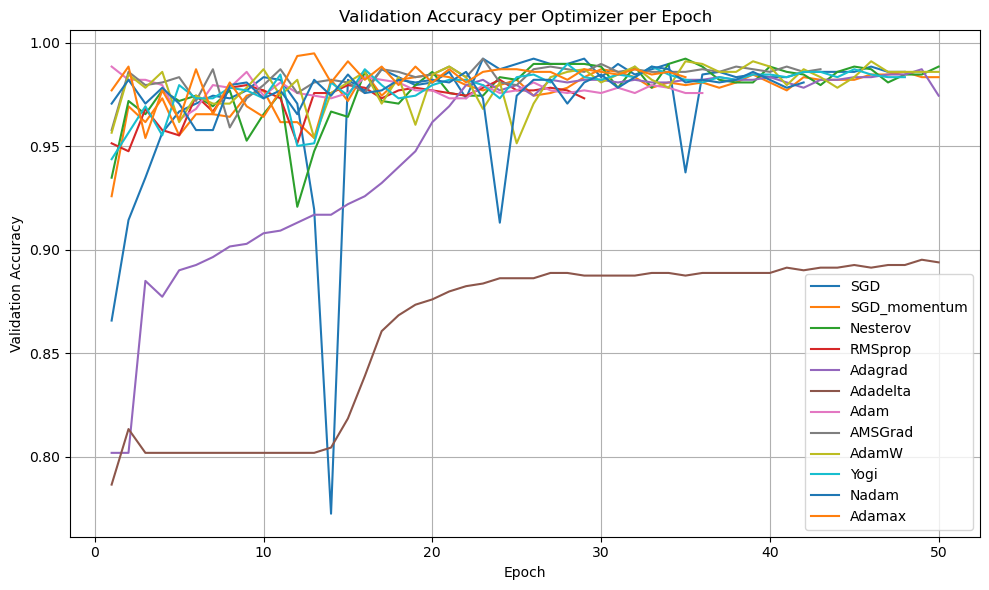

In [23]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


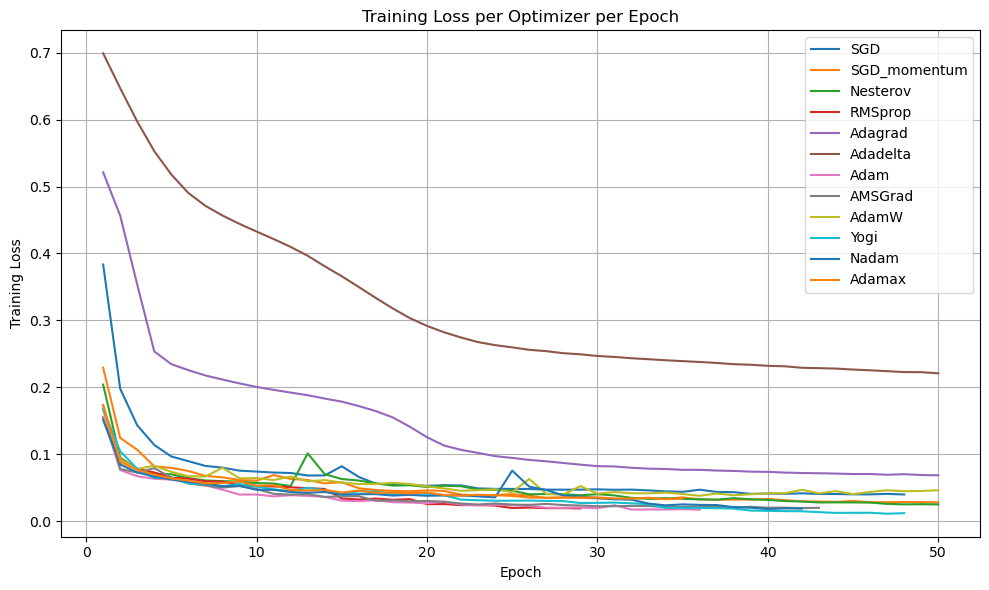

In [24]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
final_df.to_csv('Predictive-Meintenance.csv', index=False)

In [41]:
# # Define and train the LSTM model
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(window_length, X_train.shape[1])),
#     Dense(4, activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, epochs=3, validation_data=val_generator)

# # Evaluate the model on test data
# loss, accuracy = model.evaluate(test_generator)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [23]:
# # Generate predictions
# y_pred_prob = model.predict(test_generator)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Extract true labels from test generator
# y_true = []
# for i in range(len(test_generator)):
#     _, labels = test_generator[i]
#     y_true.extend(labels)
# y_true = np.argmax(y_true, axis=1)

# # Compute additional evaluation metrics
# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')
# f1 = f1_score(y_true, y_pred, average='weighted')

# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)

63/63 [==============================] - 1s 16ms/step
Precision: 0.8702920358967482
Recall: 0.8766233766233766
F1 Score: 0.8727047839848051


In [24]:
# # Define the NeuralNetworkModel class
# class NeuralNetworkModel:
#     def __init__(self):
#         self.model = None

#     def build_ann(self, input_shape, optimizer):
#         self.model = Sequential([
#             LSTM(50, activation='relu', input_shape=(window_length, X_train.shape[1])),
#             Dense(4, activation='softmax')
#         ])
#         self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     def train(self, X_train, X_val, epochs, batch_size):
#         early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
#         return self.model.fit( X_train, X_val, epochs=1, batch_size=32, callbacks=[early_stopping, reduce_lr]
#         # return self.model.fit( X_train, X_val, epochs=1, batch_size=32
#     )

    
#     def evaluate(self, X_test):
#         y_pred_prob = self.model.predict(X_test)
#         y_pred = np.argmax(y_pred_prob, axis=1)
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred, average='weighted')
#         recall = recall_score(y_test, y_pred, average='weighted')
#         f1 = f1_score(y_test, y_pred, average='weighted')
#         return accuracy, precision, recall, f1

In [59]:
# Select features with high correlation to the target
k_best_features = SelectKBest(score_func=f_regression, k=5)
k_best_features.fit(df, y)
selected_features = df.columns[k_best_features.get_support(indices=True)].tolist()


C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
# Select the relevant columns from the DataFrame
X_selected = df[selected_features]

In [105]:
X_selected

,S1_Temp,S1_Light,S2_Light,S3_Light,S7_PIR
0,24.94,121,34,53,0
1,24.94,121,33,53,0
2,25.00,121,34,53,0
3,25.00,121,34,53,0
4,25.00,121,34,54,0
...,...,...,...,...,...
10124,25.06,6,7,33,0
10125,25.06,6,7,34,0
10126,25.13,6,7,34,0
10127,25.13,6,7,34,0


In [61]:
df["Room_Occupancy_Count"] = y

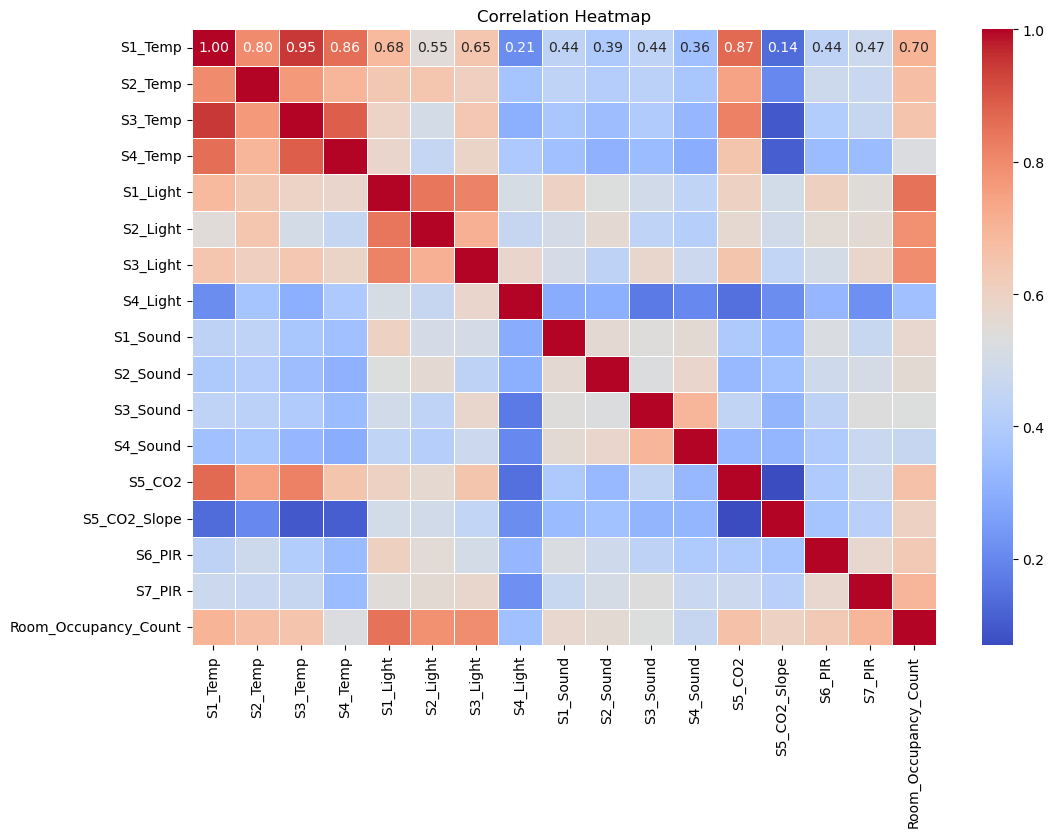

In [66]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [67]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_selected)

In [68]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)


In [76]:
X_train.shape

(7292, 5)

In [104]:
X_train

array([[0.        , 0.73333333, 0.13178295, 0.18928571, 0.        ],
       [0.        , 0.73333333, 0.12790698, 0.18928571, 0.        ],
       [0.04166667, 0.73333333, 0.13178295, 0.18928571, 0.        ],
       ...,
       [0.25694444, 0.        , 0.        , 0.        , 0.        ],
       [0.25694444, 0.        , 0.        , 0.        , 0.        ],
       [0.25694444, 0.        , 0.        , 0.        , 0.        ]])

In [129]:
# Define window length for TimeseriesGenerator
window_length = 24 # Assuming a window length of 24 samples

# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(X_train, y_train, length=window_length, batch_size=1)

# Create TimeseriesGenerator for validation data
val_generator = TimeseriesGenerator(X_val, y_val, length=window_length, batch_size=1)

# Create TimeseriesGenerator for test data
test_generator = TimeseriesGenerator(X_test, y_test, length=window_length, batch_size=1)

In [130]:
train_generator.data.shape[1]

5

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_length, train_generator.data.shape[1]), return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(1)
])

# # Compile the model
# model.compile(optimizer='adam', loss='mse')

# # Print the model summary
# model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, epochs=50, validation_data=val_generator)

# # Evaluate the model on test data
# loss, accuracy = model.evaluate(test_generator)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [135]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

KeyError: 24